In [1]:
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import pm4py
from pm4py.statistics.traces.log import case_statistics
from datetime import datetime

common_path = "/Users/abdalrhman/Documents/bdma-thesis/python/data/"

driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Croma2023"))
session = driver.session()

In [12]:
query = f'''match (r:Run {{EntityType:"Kit"}})
where r.durationInMinutes > 0 and r.numberOfPieces > 1
return count(r)'''
session.run(query).data()

[{'count(r)': 4459}]

In [4]:
query = f'''match (r:Run {{EntityType:"Kit", numberOfPieces: 1}}) <- [:CORR] - (e1:Event {{Activity:"Entrada Material Sucio"}}) - [:DF_CASE] -> 
(e2:Event {{Activity:"Cargado en carro L+D"}}) 
match (r) <- [:CORR] - (e2) - [:DF_CASE] -> (e3:Event {{Activity:"Carga L+D iniciada"}})
match (r) <- [:CORR] - (e3) - [:DF_CASE] -> (e4:Event {{Activity:"Carga L+D liberada"}}) 
match (r) <- [:CORR] - (e4) - [:DF_CASE] -> (e5:Event {{Activity:"Montaje"}}) 
match (r) <- [:CORR] - (e5) - [:DF_CASE] -> (e6:Event {{Activity:"Producción montada"}})
match (r) <- [:CORR] - (e6) - [:DF_CASE] -> (e7:Event {{Activity:"Composición de cargas"}})
match (r) <- [:CORR] - (e7) - [:DF_CASE] -> (e8:Event {{Activity:"Carga de esterilizador liberada"}}) 
where r.durationInMinutes > 0
return count(r)'''
session.run(query).data()

[{'count(r)': 9575}]

In [14]:
query = f'''match (r:Run {{EntityType:"Kit", numberOfPieces: 1}}) <- [:CORR] - (e1:Event {{Activity:"Entrada Material Sucio"}}) - [:DF_CASE] -> 
(e2:Event {{Activity:"Cargado en carro L+D"}}) 
match (r) <- [:CORR] - (e2) - [:DF_CASE] -> (e3:Event {{Activity:"Carga L+D iniciada"}})
match (r) <- [:CORR] - (e3) - [:DF_CASE] -> (e4:Event {{Activity:"Carga L+D liberada"}}) 
match (r) <- [:CORR] - (e4) - [:DF_CASE] -> (e5:Event {{Activity:"Montaje"}}) 
match (r) <- [:CORR] - (e5) - [:DF_CASE] -> (e6:Event {{Activity:"Producción montada"}})
match (r) <- [:CORR] - (e6) - [:DF_CASE] -> (e7:Event {{Activity:"Composición de cargas"}})
match (r) <- [:CORR] - (e7) - [:DF_CASE] -> (e8:Event {{Activity:"Carga de esterilizador liberada"}}) 
where r.durationInMinutes > 0
with r
match (r) <- [:CORR] - (e:Event)
return r.CaseID as CaseID, e.Activity as Activity, e.Nombre as Nombre, e.KitID as KitID, e.Usuario as resource, e.timestamp as timestamp, e.`Código` as Codigo, e.NS as NS 
'''
session.run(query).data()
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()
event_log = pm4py.format_dataframe(df, case_id='CaseID', activity_key='Activity', timestamp_key='timestamp')
event_log = pm4py.convert_to_event_log(event_log)
len(pm4py.get_variants_as_tuples(event_log))

Failed to write data to connection IPv4Address(('localhost', 7687)) (IPv4Address(('127.0.0.1', 7687)))


150

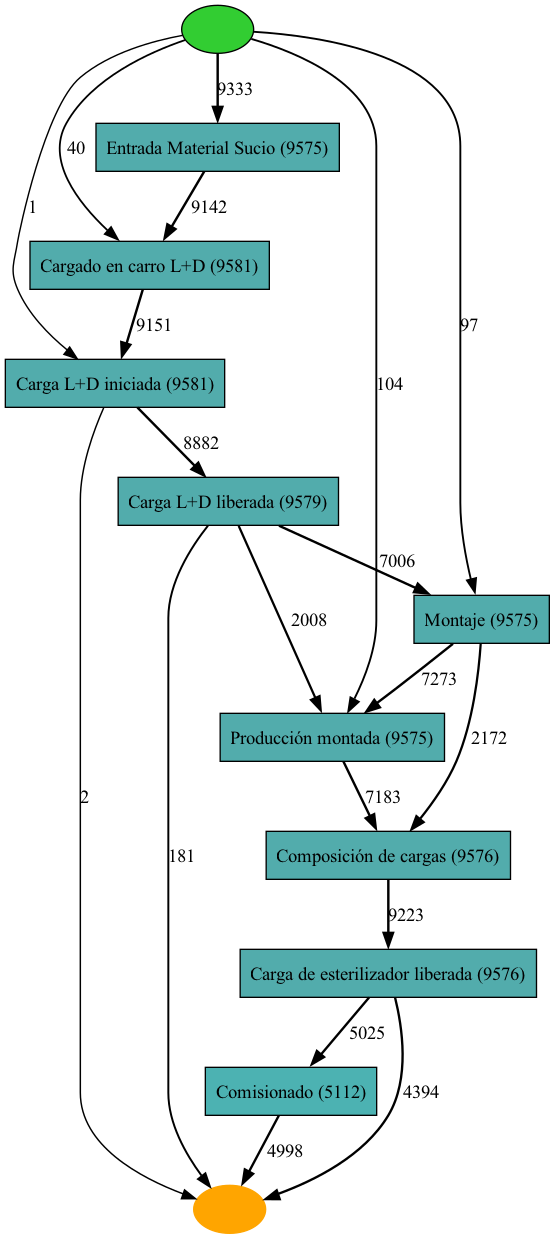

In [19]:
heu_net = pm4py.discover_heuristics_net(event_log, dependency_threshold=0)
pm4py.view_heuristics_net(heu_net)

In [9]:
query = f'''match (r:Run {{EntityType:"Kit"}}) <- [:CORR] - (e:Event)
where r.durationInMinutes > 0 and r.numberOfPieces > 1
return r.CaseID as CaseID, e.Activity as Activity, e.Nombre as Nombre, e.KitID as KitID, e.Usuario as resource, e.timestamp as timestamp, e.`Código` as Codigo, e.NS as NS 
'''
session.run(query).data()
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()
event_log = pm4py.format_dataframe(df, case_id='CaseID', activity_key='Activity', timestamp_key='timestamp')
event_log = pm4py.convert_to_event_log(event_log)
len(pm4py.get_variants_as_tuples(event_log))

2549

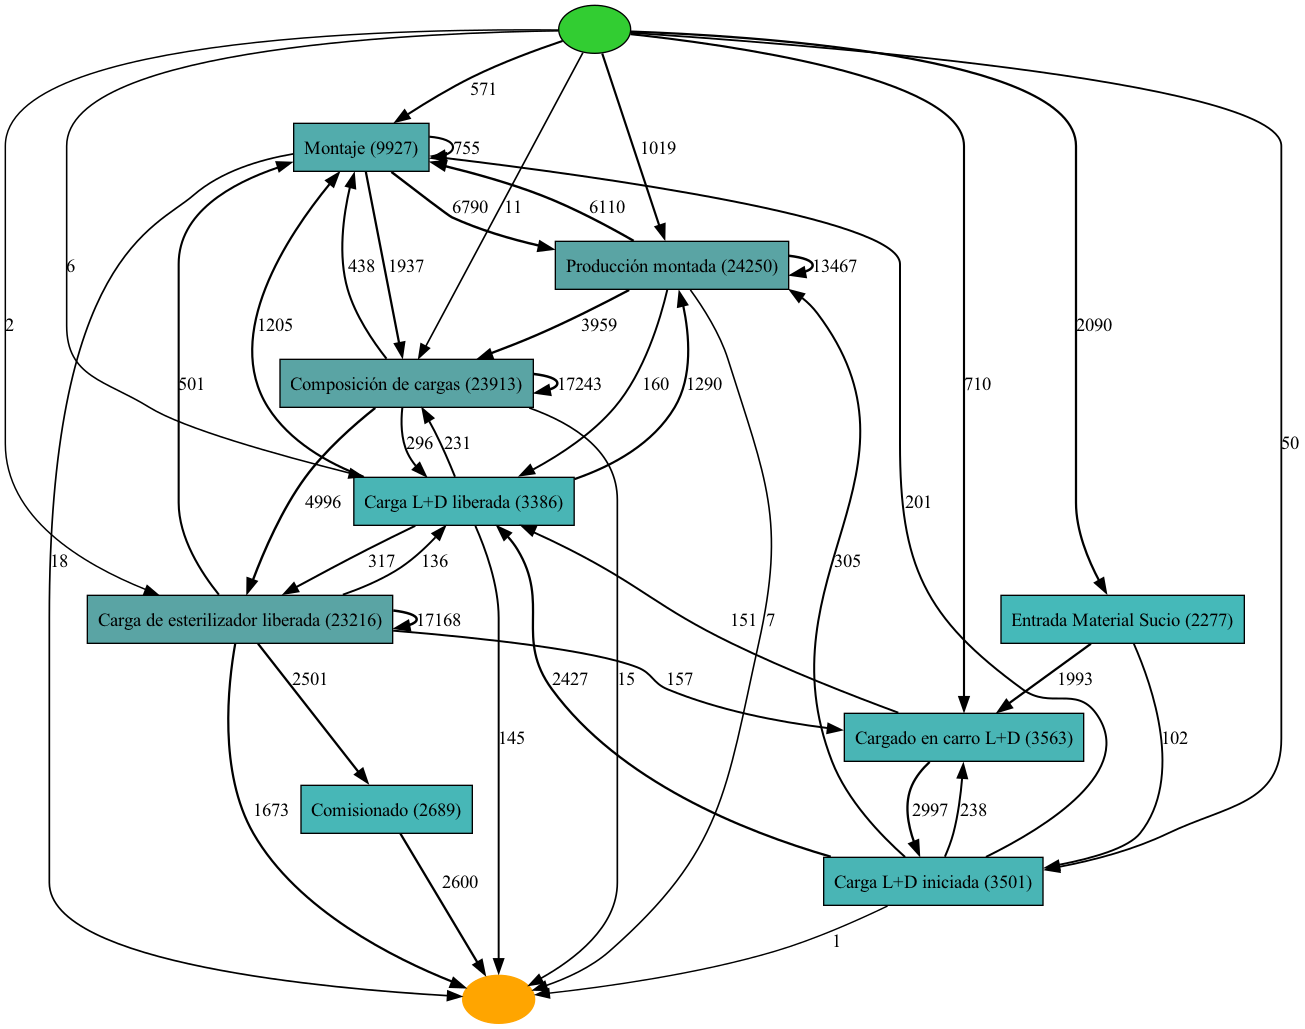

In [10]:
heu_net = pm4py.discover_heuristics_net(event_log, dependency_threshold=0.9)
pm4py.view_heuristics_net(heu_net)

In [4]:
query = f'''match (r:Run {{EntityType:"Kit"}}) <- [:CORR] - (e1:Event {{Activity:"Entrada Material Sucio"}}) - [:DF_CASE] -> 
(e2:Event {{Activity:"Cargado en carro L+D"}}) 
match (r) <- [:CORR] - (e2) - [:DF_CASE] -> (e3:Event {{Activity:"Carga L+D iniciada"}})
match (r) <- [:CORR] - (e3) - [:DF_CASE] -> (e4:Event {{Activity:"Carga L+D liberada"}}) 
match (r) <- [:CORR] - (e4) - [:DF_CASE] -> (e5:Event {{Activity:"Montaje"}}) 
where e5.Cant > 1
return r.CaseID, e5.Cant'''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df.head()

,r.CaseID,e5.Cant
0,EXT-MICRO.SUELTO-0-CN34816,3
1,HUBU-CCEE.ORL.BD883R-0-CN35348,2
2,HUBU-CCEE.ORL.GF363R-0-CN35351,2
3,HUBU-CCEE.ORL.GF362R-0-CN34945,2
4,HUBU-CCEE.ORL.OK037R-0-CN35352,2


In [15]:
print(len(df))

6658


In [6]:
columns = ['r.CaseID', 'e5.Cant']
df_data2 = pd.DataFrame(columns=columns)

for index, row in df.iterrows():
    query = f'''match (r:Run {{EntityType:"Kit", CaseID:"{row['r.CaseID']}"}}) <- [:CORR] - (e1:Event {{Activity:"Entrada Material Sucio"}}) - [:DF_CASE] -> 
(e2:Event {{Activity:"Cargado en carro L+D"}}) 
match (r) <- [:CORR] - (e2) - [:DF_CASE] -> (e3:Event {{Activity:"Carga L+D iniciada"}})
match (r) <- [:CORR] - (e3) - [:DF_CASE] -> (e4:Event {{Activity:"Carga L+D liberada"}}) 
match (r) <- [:CORR] - (e4) - [:DF_CASE] -> (e5:Event {{Activity:"Montaje"}}) ''' 
    for i in range (row['e5.Cant']):
        query = query + f''' 
        match (r) <- [:CORR] - (e{5+i}) - [:DF_CASE] -> (e{6+i}:Event {{Activity:"Producción montada"}})'''
    query = query + ''' return r.CaseID, e5.Cant limit 1'''
    df_data2 = df_data2.append(session.run(query).to_df(), ignore_index=True)
df_data2.head()

Failed to read from defunct connection IPv4Address(('localhost', 7687)) (IPv4Address(('127.0.0.1', 7687)))


ServiceUnavailable: Failed to read from defunct connection IPv4Address(('localhost', 7687)) (IPv4Address(('127.0.0.1', 7687)))